In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Utils.ga import *
from Utils.tradingrule import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data preprocessing

In [4]:
data = pd.read_csv("data/eurusd_5m_20200101_20210708.csv")
data = data[['Open', 'High', 'Low', 'Close']]
data.head()

,Open,High,Low,Close
0,1.12076,1.12076,1.12076,1.12076
1,1.12076,1.12076,1.12076,1.12076
2,1.12076,1.12076,1.12076,1.12076
3,1.12076,1.12076,1.12076,1.12076
4,1.12076,1.12076,1.12076,1.12076


In [5]:
X_train = data.loc[:len(data)//2]
X_test = data.loc[len(data)//2:]

In [6]:
%%time
trading_rule_params = trainTradingRuleFeatures(X_train)

Training Rule1 score is: 0.379
Training Rule2 score is: 0.379
Training Rule3 score is: 0.427
Training Rule4 score is: 0.399
Training Rule5 score is: 0.346
Training Rule6 score is: 0.407
Training Rule7 score is: 0.411
Training Rule8 score is: 0.347
Training Rule9 score is: 0.418
Training Rule10 score is: 0.441
Training Rule11 score is: 0.342
Training Rule12 score is: 0.436
Training Rule13 score is: 0.340
Training Rule14 score is: 0.193
Training Rule15 score is: 0.198
Training Rule16 score is: 0.097
CPU times: user 4min 10s, sys: 239 ms, total: 4min 10s
Wall time: 4min 10s


In [7]:
%%time
X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
X_trading_rule_test = getTradingRuleFeatures(X_test, trading_rule_params)

CPU times: user 4.98 s, sys: 12 ms, total: 5 s
Wall time: 5 s


### Genetic Algorithm to Find the Optimal Combination of Rules

In [8]:
def evaluate(position, logr):
    port_r = logr*position
    score = port_r.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("The return over the period is: {:.2f}%".format(score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r.cumsum())*100))
    sr_train = port_r.mean()/port_r.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))

### 思考下为什么曲线会突然就往下打下去，SSR应该是maximize优化

(array([0]),)
[0.0001905353122815811, 0.00019388214708355772, 0.00014758600692159506, 9.66318553598843e-05, 7.771453151010964e-05, 6.799933530002796e-05, 6.788127246893028e-05, 6.756085972074976e-05, 6.558704912224343e-05, 6.67010567656011e-05, 6.606627971953803e-05, 6.635197438578789e-05, 6.445842036139359e-05, 6.572709599758198e-05, 6.512911373484238e-05, 6.585483703280789e-05, 6.551893669912069e-05, 6.584158580437844e-05, 6.580212273084374e-05, 6.760559326453106e-05, 6.55114027530971e-05, 6.532274580186934e-05, 6.704818511638203e-05, 6.511403774767432e-05, 6.558795397747821e-05, 6.724725748627525e-05, 6.669706121870398e-05, 6.617306355936374e-05, 6.598687423398277e-05, 6.372011040829119e-05, 6.655534439884377e-05, 6.656463112205376e-05, 6.524090451962282e-05, 6.65737491391145e-05, 6.600241574230919e-05, 6.499007358800021e-05, 6.487048846276956e-05, 6.491404830206616e-05, 6.364299704962584e-05, 6.335489896499263e-05, 6.486407692702597e-05, 6.531248610335519e-05, 6.599242109252776e-05

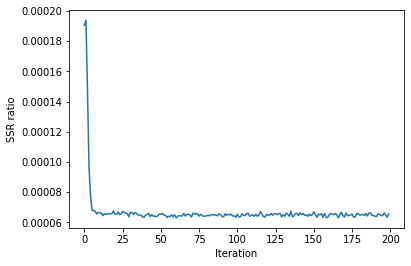

CPU times: user 1min 6s, sys: 2.69 s, total: 1min 8s
Wall time: 1min 8s


In [9]:
%%time
max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, sol_per_pop=10, num_parents_mating=6, num_generations = 200)

In [10]:
position = (X_trading_rule_train.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
position /= np.max(abs(position))
print('Training data evaluation:')
evaluate(position, X_trading_rule_train.logr)
port_r_train = X_trading_rule_train.logr*position

Training data evaluation:
The maximum position is 1.000, the mean postiion is 0.579169.
The return over the period is: 33.27%
Maximum drawdown is: -0.474%
SR ratio is: 5.477


In [11]:
position = (X_trading_rule_test.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
position /= np.max(abs(position))
print('Testing data evaluation:')
evaluate(position, X_trading_rule_test.logr)
port_r_test = X_trading_rule_test.logr*position

Testing data evaluation:
The maximum position is 1.000, the mean postiion is 0.592056.
The return over the period is: 30.38%
Maximum drawdown is: -0.322%
SR ratio is: 7.322


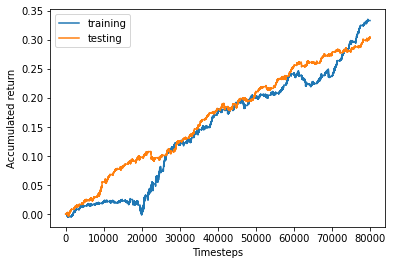

In [12]:
plt.plot(range(len(port_r_train)), port_r_train.cumsum(), label='training')
plt.plot(range(len(port_r_test)), port_r_test.cumsum(), label='testing')
plt.xlabel('Timesteps')
plt.ylabel('Accumulated return')
plt.legend()
plt.show()